In [1]:
%load_ext autoreload
%autoreload 2

### Imports

In [1]:
import tensorflow as tf
from psychrnn.backend.models.basic import Basic
from psychrnn.backend.gain.basic2 import Basic2
from psychrnn.backend.gain.loss import rt_mask_mse_06, rt_mask_mse_07, rt_mask_mse_08
from psychrnn.tasks.checker import Checkerboard2AFC

from tqdm import tqdm
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

import os

### Initialize Task

In [2]:
experiment = 'interactive'
name = 'basic'

In [3]:
dt = 10
tau = 50
T = 3000
N_batch = 50
N_rec = 100

In [4]:
task = Checkerboard2AFC(dt=dt, tau=tau, T=T, N_batch=N_batch)

### Set up parameters

In [5]:
network_params = task.get_task_params()
network_params['name'] = name
network_params['N_rec'] = N_rec
network_params['rec_noise'] = 0.1

network_params["transfer_function"] = tf.nn.relu
network_params["output_transfer_function"] = tf.nn.sigmoid

network_params["loss_function"] = "rt_mask_mse"
network_params["rt_mask_mse"] = rt_mask_mse_07


In [6]:
try:
    model.destruct()
except:
    pass

model = Basic2(network_params)

### Train Model

In [7]:
trials = 25000
train_params = {}
train_params['save_weights_path'] =  "./weihts/basic2_w"
train_params['training_iters'] = trials
train_params['learning_rate'] = .001
train_params['loss_epoch'] = 10
train_params['save_training_weights_epoch'] = 1000 / N_batch
train_params['training_weights_path'] = None

In [8]:
losses, initialTime, trainTime = model.train(task, train_params)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Iter 500, Minibatch Loss= 0.093258
Iter 1000, Minibatch Loss= 0.073335
Iter 1500, Minibatch Loss= 0.048163
Iter 2000, Minibatch Loss= 0.047648
Iter 2500, Minibatch Loss= 0.041926
Iter 3000, Minibatch Loss= 0.032225
Iter 3500, Minibatch Loss= 0.036314
Iter 4000, Minibatch Loss= 0.036962
Iter 4500, Minibatch Loss= 0.029616
Iter 5000, Minibatch Loss= 0.033873
Iter 5500, Minibatch Loss= 0.023717
Iter 6000, Minibatch Loss= 0.018838
Iter 6500, Minibatch Loss= 0.023203
Iter 7000, Minibatch Loss= 0.021014
Iter 7500, Minibatch Loss= 0.033906
Iter 8000, Minibatch Loss= 0.025160
Iter 8500, Minibatch Loss= 0.014800
Iter 9000, Minibatch Loss= 0.018611
Iter 9500, Minibatch Loss= 0.013591
Iter 10000, Minibatch Loss= 0.013650
Iter 10500, Minibatch Loss= 0.017861
Iter 11000, Minibatch Loss= 0.020048
Iter 11500, Minibatch Loss= 0.016670
Iter 12000, Minibatch Loss= 0.011693
Iter 12500, Minibatch Loss= 0.011242
I

Text(0.5, 1.0, 'Loss During Training')

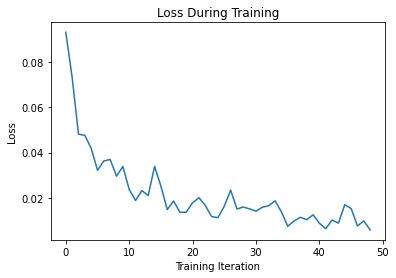

In [9]:
plt.plot(losses)
plt.ylabel("Loss")
plt.xlabel("Training Iteration")
plt.title("Loss During Training")

### Test on 10000 trials to examine performance

In [10]:
trials = 10000
batches = int(np.ceil(trials / N_batch))

rnn_state = np.zeros((trials, task.N_steps, model.N_rec))
rnn_out = np.zeros((trials, task.N_steps, model.N_out))

coherence = np.zeros(trials)
green_side = np.zeros(trials)
target_onset = np.zeros(trials)
checker_onset = np.zeros(trials)

decision = np.zeros(trials)
rt = np.zeros(trials)

In [11]:
for b in tqdm(range(batches)):
    x, y, m, params = task.get_trial_batch()
    outputs, states, inputs = model.test(x)
    
    start_index = N_batch * b
    end_index = N_batch * (b + 1)
    rnn_state[start_index:end_index] = states
    rnn_out[start_index:end_index] = outputs
    
    thr = np.where(outputs > 0.7)
    
    for i in range(N_batch):
        index = start_index + i
        
        coherence[index] = params[i]["coherence"]
        green_side[index] = params[i]["side"]
        target_onset[index] = params[i]["target_onset"]
        checker_onset[index] = params[i]["checker_onset"]
        
        thr_time = thr[1][thr[0]==i][0] if sum(thr[0]==i) > 0 else outputs.shape[1]
        thr_unit = thr[2][thr[0]==i][0] if sum(thr[0]==i) > 0 else np.argmax(outputs[i, -1])
        decision[index] = thr_unit
        rt[index] = thr_time*task.dt - target_onset[index] - checker_onset[index]       

100%|██████████| 200/200 [01:01<00:00,  3.23it/s]


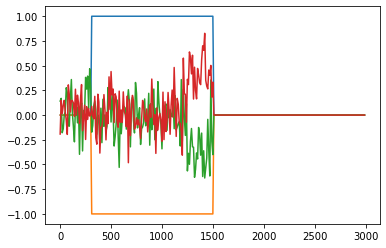

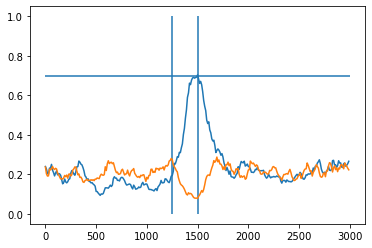

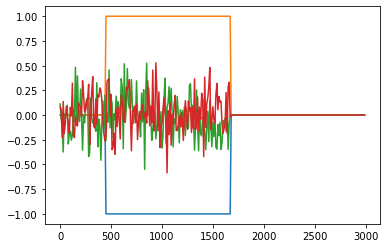

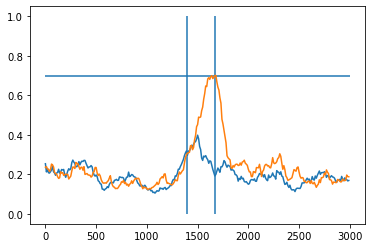

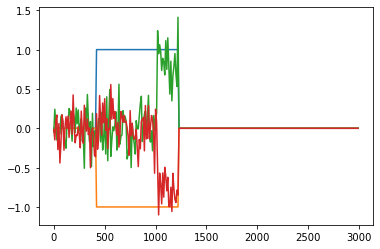

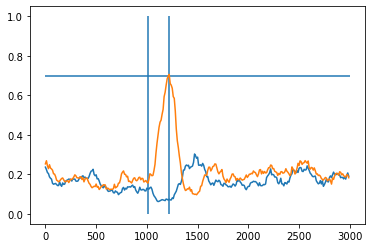

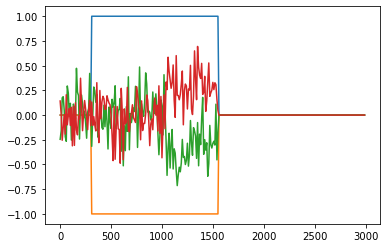

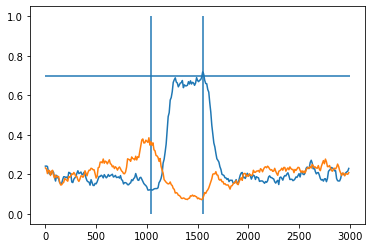

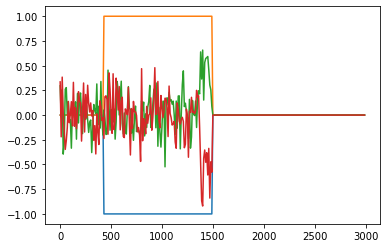

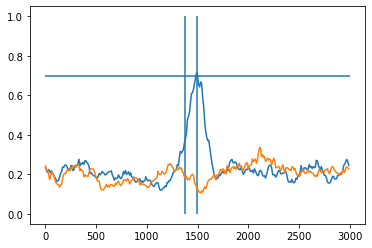

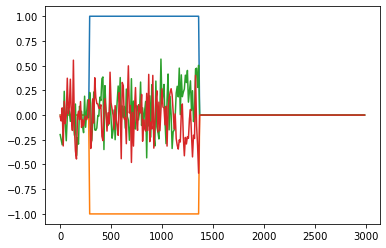

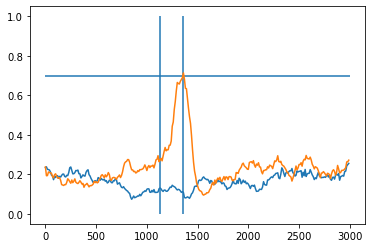

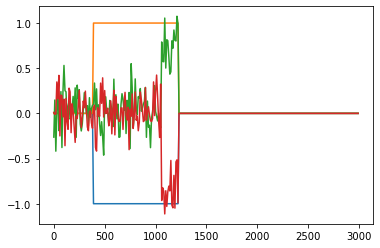

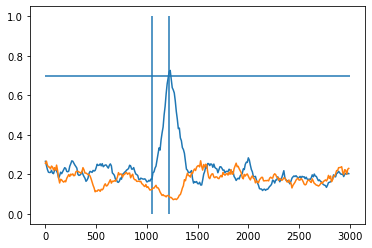

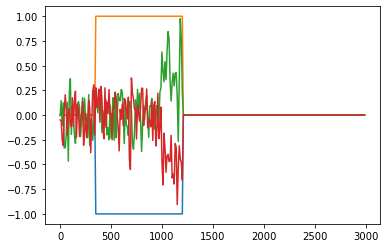

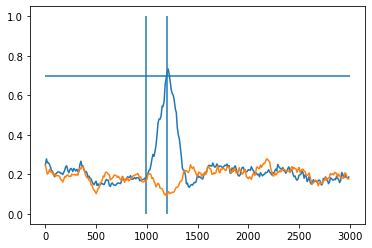

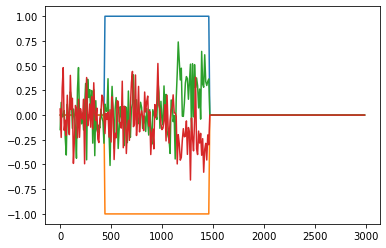

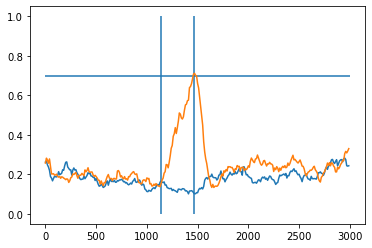

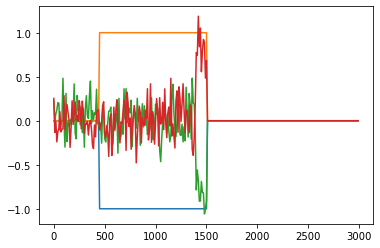

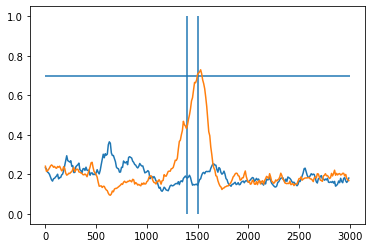

In [12]:
#onsets = [p["onset_time"] for p in params]
onsets = target_onset[-N_batch:] + checker_onset[-N_batch:]
rts = rt[-N_batch:]
for i in range(10):
    plt.figure()
    plt.plot(np.arange(0, 3000, 10), inputs[i, :, 0])
    plt.plot(np.arange(0, 3000, 10), inputs[i, :, 1])
    plt.plot(np.arange(0, 3000, 10), inputs[i, :, 2])
    plt.plot(np.arange(0, 3000, 10), inputs[i, :, 3])

    plt.figure()
    plt.plot(np.arange(0, 3000, 10), outputs[i, :, 0])
    plt.plot(np.arange(0, 3000, 10), outputs[i, :, 1])
    
    plt.vlines(onsets[i], 0, 1)
    plt.vlines(onsets[i] + rts[i], 0, 1)
    plt.hlines(0.7, 0, 3000)

In [13]:
correct_side = np.array([gs if coh > 0 else abs(gs-1) for coh, gs in zip(coherence, green_side)])
green_decision = np.array([int(dec == gs) for dec, gs in zip(decision, green_side)])
checker_df = pd.DataFrame({'trial' : np.arange(trials),
                           'coherence' : coherence,
                           'coherence_bin' : np.round(coherence, 1),
                           'green_side' : green_side,
                           'correct_side' : correct_side,
                           'target_onset' : target_onset,
                           'checker_onset' : checker_onset,
                           'decision' : decision,
                           'green_decision' : green_decision,
                           'decision_time' : rt,
                           'correct_decision' : (decision == correct_side).astype(int)})
checker_mean = checker_df.groupby('coherence_bin').mean().reset_index()


In [16]:
checker_mean

,coherence_bin,trial,coherence,green_side,correct_side,target_onset,checker_onset,decision,green_decision,decision_time,correct_decision
0,-0.9,4785.520295,-0.873683,0.498155,0.501845,371.339483,747.963100,0.501845,0.000000,153.612546,1.000000
1,-0.8,5046.182444,-0.800980,0.490534,0.509466,371.958692,749.524957,0.509466,0.000000,159.841652,1.000000
2,-0.7,4839.984183,-0.700794,0.488576,0.511424,371.158172,748.237258,0.511424,0.000000,175.947276,1.000000
3,-0.6,5119.364151,-0.598575,0.454717,0.545283,375.194340,753.986792,0.545283,0.000000,190.950943,1.000000
4,-0.5,4926.397436,-0.501327,0.483516,0.516484,375.010989,752.857143,0.516484,0.000000,219.000000,1.000000
5,-0.4,5152.200000,-0.402029,0.510909,0.489091,375.583636,754.905455,0.489091,0.000000,252.838182,1.000000
6,-0.3,5045.488117,-0.298844,0.515539,0.484461,379.906764,734.530165,0.484461,0.000000,305.581353,1.000000
7,-0.2,5103.351351,-0.200683,0.494932,0.505068,378.331081,758.327703,0.505068,0.000000,386.500000,1.000000
8,-0.1,4876.503546,-0.098578,0.503546,0.496454,371.824468,749.246454,0.494681,0.001773,888.290780,0.998227
9,-0.0,4786.699620,0.000335,0.475285,0.460076,375.467681,760.072243,0.359316,0.427757,1713.167300,0.819392


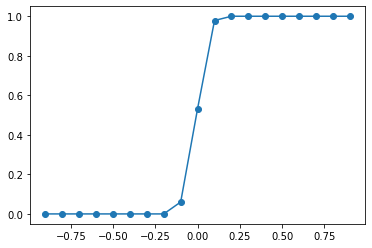

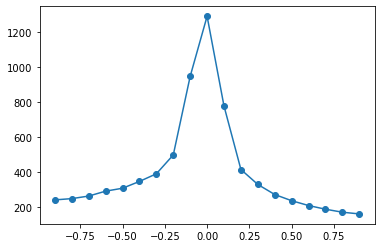

In [14]:
plt.figure()
plt.plot(checker_mean['coherence_bin'], checker_mean['green_decision'])
plt.scatter(checker_mean['coherence_bin'], checker_mean['green_decision'])

plt.figure()
plt.plot(checker_mean['coherence_bin'], checker_mean['decision_time'])
plt.scatter(checker_mean['coherence_bin'], checker_mean['decision_time'])

# RT within same coherence

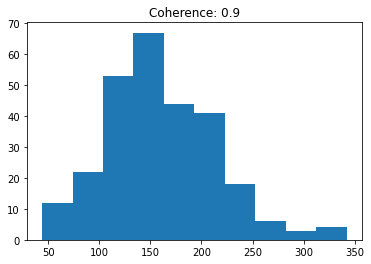

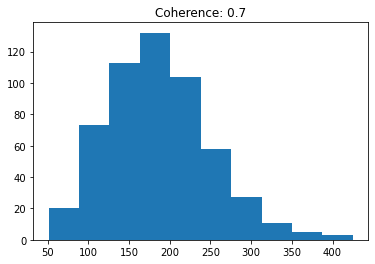

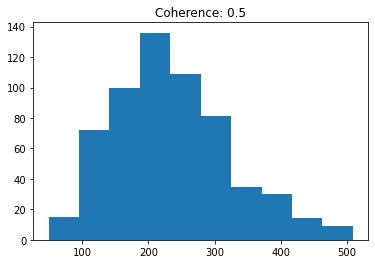

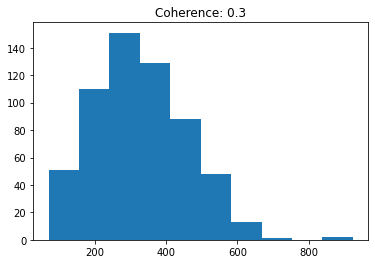

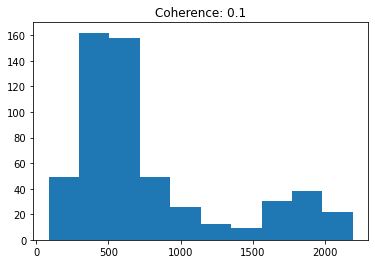

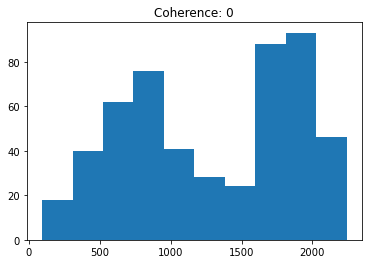

In [15]:
for i in [0.9,0.7,0.5,0.3,0.1,0]:
    a = checker_df['coherence_bin'] == i
    groupCo = checker_df.loc[a,:]
    RT = groupCo["decision_time"]
    plt.figure()
    plt.hist(RT)
    plt.title("Coherence: " + str(i))

In [16]:
model.destruct()